In [266]:
import numpy as np
import uproot as ur
import awkward as ak
import sys
sys.path.append('/home/mjovanovic/Work/LCStudies')
from data import particle_data_visualize_plot_utils as pu
import matplotlib.pyplot as plt
np.set_printoptions(threshold=sys.maxsize)
import time

Helper functions

In [3]:
def flatten_event_to_cells(event):
    return np.array([cell for clus in event for cell in clus])

def flatten_events_and_clus_to_events(events_data):
    return [[cell_data for clus_data in event_data for cell_data in clus_data] for event_data in events_data]

def flatten_events_to_clus(events_data):
    return [clus_data for event_data in events_data for clus_data in event_data]

def flatten_one_layer(data):
    return [data_layer2 for data_layer1 in data for data_layer2 in data_layer1]

def flatten_layers(data, num_layers=1):
    for i in range(num_layers):
        data = flatten_one_layer(data)
    return data

def flatten_clus_in_events(events):
    return [[cell for clus in event for cell in clus] for event in events]

def flatten_events_to_cells(events_data):
    return [cell_data for clus_data in flatten_events_to_clus(events_data) for cell_data in clus_data]

def DeltaR(etas1, phis1, etas2, phis2):
    return np.sqrt((etas1-etas2)**2 + (phis1-phis2)**2)

In [4]:
def spherical_to_cartesian(rs, phis, thetas):
    # convert to x, y, z
    x, y, z = [], [], []

    for i, r in enumerate(rs):
        x.append(r*np.cos(phis[i]))
        y.append(r*np.sin(phis[i]))
        z.append( r/np.tan(thetas[i]))

    return np.array(x), np.array(y), np.array(z)

3D Visualization functions

In [5]:
def plot_proccessed_cells_in_line(x,y,z,cell_data, title, xlabel, ylabel, zlabel, colour_theme, bar_label, event_idx=None, vmin=None, vmax=None, same_axis=True):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    fig.set_size_inches(5*len(cell_data), 5)
    for i, cell_data_i in enumerate(cell_data):
        ax = fig.add_subplot(1, len(cell_data), i + 1, projection='3d')
        x_i = x[i] if len(x) > 1 else x[0]
        y_i = y[i] if len(y) > 1 else y[0]
        z_i = z[i] if len(z) > 1 else z[0]
        xlabel_i = xlabel[i] if len(xlabel) > 1 else xlabel[0]
        ylabel_i = ylabel[i] if len(ylabel) > 1 else ylabel[0]
        zlabel_i = zlabel[i] if len(zlabel) > 1 else zlabel[0]
        title_i = title[i] if len(title) > 1 else title[0]

        if bar_label[i] == "Clusters":
            for cluster_idx, clus_x in enumerate(processed_event_data["x"][event_idx]):
                ax.scatter(processed_event_data["z"][event_idx][cluster_idx], clus_x, processed_event_data["y"][event_idx][cluster_idx], label="cluster " + str(cluster_idx + 1))
                ax.legend()
        elif bar_label[i] == "Pi+/- frac class" or bar_label[i] == "Pred EM frac class":
            cut_em_class = np.array(cell_data_i) == 1
            clus_x = np.array(x_i)
            clus_y = np.array(y_i)
            clus_z = np.array(z_i)
            ax.scatter(clus_z[cut_em_class], clus_x[cut_em_class], clus_y[cut_em_class], color="fuchsia")
            ax.scatter(clus_z[~cut_em_class], clus_x[~cut_em_class], clus_y[~cut_em_class], color="cyan")  
        else:
            p = ax.scatter(z_i, x_i, y_i, c=cell_data_i, vmin=vmin[i], vmax=vmax[i], cmap=colour_theme[i])
            #if bar_label[i] != "EM frac class":
            fig.colorbar(p, label=bar_label[i], fraction=0.025, pad=0.15)

        ax.set_xlabel(xlabel_i)
        ax.set_ylabel(ylabel_i)
        ax.set_zlabel(zlabel_i)
        plt.title(title_i)
    plt.show()


# plot 3d event info
def plot_event_3d_info(event_idx, pipm_frac, empty_contr_frac, pipm_frac_class=None):
    print("event index:", event_idx)
    print("pipm_frac:", pipm_frac[empty_contr_frac])
    
    file = ur.open("/data/atlas/data/rho_delta/rho_small.root")
    cell_geo_tree = file["CellGeo"]
    cell_geo_data = cell_geo_tree.arrays(library='np')
    cell_geo_ID = cell_geo_data['cell_geo_ID'][0]
    sorter = np.argsort(cell_geo_ID)
    cell_IDs = events_arr['cluster_cell_ID'][event_idx]
    print("num cells:", len(cell_IDs))
    cell_ID_map = sorter[np.searchsorted(cell_geo_ID, cell_IDs, sorter=sorter)]

    etas = cell_geo_data["cell_geo_eta"][0][cell_ID_map]
    phis = cell_geo_data["cell_geo_phi"][0][cell_ID_map]
    rPerps = cell_geo_data["cell_geo_rPerp"][0][cell_ID_map]
    samplings = np.array(cell_geo_data["cell_geo_sampling"][0][cell_ID_map])

    thetas = [2*np.arctan(np.exp(-eta)) for eta in etas]
    x, y, z = spherical_to_cartesian(rPerps, phis, thetas)
    
    title = ["Sampling layers", "Cell energy", "Pi0 frac", "Pi0 frac class"]
    xlabel = ["z"]
    ylabel = ["x"]
    zlabel = ["y"]

    colour_theme = [plt.cm.tab20b, plt.cm.magma, plt.cm.viridis_r, plt.cm.cool, plt.cm.cool]
    bar_label = ["Sampling layers", "Cell energy (log(GeV))", "Pi0 frac", "Pi0 frac class"]
    vmin = [0, None , 0, 0]
    vmax = [23, None, 1, 1]
    cell_data = [samplings[~empty_contr_frac], np.log10(events_arr["cluster_cell_E"][event_idx])[~empty_contr_frac], pipm_frac[~empty_contr_frac]]#, pipm_frac_class]
    
    plot_proccessed_cells_in_line([x[~empty_contr_frac]], [y[~empty_contr_frac]], [z[~empty_contr_frac]], cell_data, title, xlabel, ylabel, zlabel, colour_theme, bar_label, event_idx, vmin, vmax)

Load rho event tree

In [310]:
#rho_root_data = ur.open("/data/mjovanovic/cell_particle_deposit_learning/rho_npy_files/rho_full_500.root")
#events = rho_root_data["EventTree"]
#events_arr = events.arrays(library="ak")
#events_arr_np = events.arrays(library="np")
rho_npy_data = np.load("/data/mjovanovic/cell_particle_deposit_learning/rho_npy_files/rho_full_len_50000_i_0.npy", allow_pickle=True)
events_arr = rho_npy_data.item()

In [9]:
# find unique sets of truth particles
pgIds_pad = []
for event_idx, event_pgIds in enumerate(events_arr["truthPartPdgId"]):
    pgIds_pad.append(np.zeros(8))
    pgIds_pad[event_idx][:len(event_pgIds)] = event_pgIds

unique_truth_particles, num_occurances = np.unique(pgIds_pad, return_counts=True, axis=0)
print(unique_truth_particles)
print(num_occurances)


[[-213. -211.  111.   22.   22.    0.    0.    0.]
 [-213. -211.  111.   22.   22.   22.    0.    0.]
 [-213. -211.  111.   22.   22.   22.   22.    0.]
 [ 213.  211.  111.  -11.   11.   22.    0.    0.]
 [ 213.  211.  111.   22.   22.    0.    0.    0.]
 [ 213.  211.  111.   22.   22.   22.    0.    0.]
 [ 213.  211.  111.   22.   22.   22.   22.    0.]]
[213  32   1   2 225  26   1]


In [278]:
print(events_arr.keys())

dict_keys(['runNumber', 'eventNumber', 'lumiBlock', 'coreFlags', 'mcEventNumber', 'mcChannelNumber', 'mcEventWeight', 'nTruthPart', 'G4PreCalo_n_EM', 'G4PreCalo_E_EM', 'G4PreCalo_n_Had', 'G4PreCalo_E_Had', 'truthVertexX', 'truthVertexY', 'truthVertexZ', 'truthPartPdgId', 'truthPartStatus', 'truthPartBarcode', 'truthPartPt', 'truthPartE', 'truthPartMass', 'truthPartEta', 'truthPartPhi', 'nTrack', 'trackPt', 'trackP', 'trackMass', 'trackEta', 'trackPhi', 'trackTruthParticleIndex', 'trackVisibleCalHitCaloEnergy', 'trackFullCalHitCaloEnergy', 'trackSubtractedCaloEnergy', 'trackNumberOfPixelHits', 'trackNumberOfSCTHits', 'trackNumberOfPixelDeadSensors', 'trackNumberOfSCTDeadSensors', 'trackNumberOfPixelSharedHits', 'trackNumberOfSCTSharedHits', 'trackNumberOfPixelHoles', 'trackNumberOfSCTHoles', 'trackNumberOfInnermostPixelLayerHits', 'trackNumberOfNextToInnermostPixelLayerHits', 'trackExpectInnermostPixelLayerHit', 'trackExpectNextToInnermostPixelLayerHit', 'trackNumberOfTRTHits', 'trackNu

In [311]:
# Fix 1 - cut out the negative energy deposits
events_arr["cluster_cell_hitsTruthE"] = events_arr["cluster_cell_hitsTruthE"][events_arr["cluster_cell_hitsTruthE"] >= 0]
events_arr["cluster_cell_hitsTruthIndex"] = events_arr["cluster_cell_hitsTruthIndex"][events_arr["cluster_cell_hitsTruthE"] >= 0]

# Fix 2 - cut out the events w a electron/positron, no clusters, or no cell hits
# [ 213.  211.  111.  -11.   11.   22.]
# find the occurances of this array in the list 
events_arr_resized = {}
elec_pos_events = ak.Array([np.count_nonzero(np.array(event_truthPartPdgId) == 11) > 0 for event_truthPartPdgId in events_arr["truthPartPdgId"]])
print("num events with electron/positron:", np.count_nonzero(elec_pos_events))

num_truth_contributions = np.array([[len(cell_truth_con) for clus_truth_con in event_truth_con for cell_truth_con in clus_truth_con] for event_truth_con in events_arr["cluster_cell_hitsTruthIndex"]])
no_cell_deposits = np.array([np.count_nonzero(np.array(num_truth_contributions_event) == 0) == len(num_truth_contributions_event) for num_truth_contributions_event in num_truth_contributions])
print("num events with no deposits:", np.count_nonzero(no_cell_deposits))

for key in events_arr.keys():
    events_arr_resized[key] = events_arr[key][~elec_pos_events & (ak.Array(events_arr["nCluster"]) != 0) & ~no_cell_deposits]

events_arr = events_arr_resized

# Fix 3 - cut out the padding from the end of particle deposits array
events_arr["cluster_cell_hitsTruthE"] = [[cluster_cell_hitsTruthE_clus[:len(events_arr["cluster_cell_hitsE_EM"][event_idx][clus_idx])] for clus_idx, cluster_cell_hitsTruthE_clus in enumerate(cluster_cell_hitsTruthE_event)] for event_idx, cluster_cell_hitsTruthE_event in enumerate(events_arr["cluster_cell_hitsTruthE"])]
events_arr["cluster_cell_hitsTruthIndex"] = [[cluster_cell_hitsTruthIndex_clus[:len(events_arr["cluster_cell_hitsE_EM"][event_idx][clus_idx])] for clus_idx, cluster_cell_hitsTruthIndex_clus in enumerate(cluster_cell_hitsTruthIndex_event)] for event_idx, cluster_cell_hitsTruthIndex_event in enumerate(events_arr["cluster_cell_hitsTruthIndex"])]

# Fix 4 - flatten events to cells & remove cell repeats
cellwise_data_keys = ["cluster_cell_E", "cluster_cell_hitsE_EM", "cluster_cell_hitsE_nonEM", "cluster_cell_hitsTruthE", "cluster_cell_hitsTruthIndex", "cluster_cell_ID" ]#,"cluster_cell_hitsE_Escaped", "cluster_cell_hitsE_Invisible"]

# flatten cellwise data to only be grouped by events, not clus and events
for key in cellwise_data_keys:
    events_arr[key] = flatten_clus_in_events(events_arr[key])

# iterate through the events and remove any repeated cell deposits (if 2+ of same cell ID in one event remove the extra)

# define unique versions of the cellwise data arrays
cellwise_data_unique = {}
for key in cellwise_data_keys:
    cellwise_data_unique[key + "_unique"] = []

# for every event remove the repeat 
for event_idx in np.arange(len(events_arr["cluster_cell_ID"])):
    # get the idx of the unique cell IDs
    unique_events_cells_IDs, unique_cells_idx = np.unique(events_arr["cluster_cell_ID"][event_idx], return_index=True)

    # cut the particle ID and energy deposits to just have the unique cells per event
    for key in cellwise_data_keys:
        cellwise_data_unique[key + "_unique"].append(ak.Array(events_arr[key][event_idx])[unique_cells_idx])

for key in cellwise_data_keys:
    events_arr[key] = cellwise_data_unique[key + "_unique"]

print("num events:", len(events_arr["cluster_cell_hitsTruthIndex"]))

num events with electron/positron: 75


/tmp/ipykernel_55370/1962638178.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  num_truth_contributions = np.array([[len(cell_truth_con) for clus_truth_con in event_truth_con for cell_truth_con in clus_truth_con] for event_truth_con in events_arr["cluster_cell_hitsTruthIndex"]])


num events with no deposits: 294
num events: 5634


Truth contributions analysis

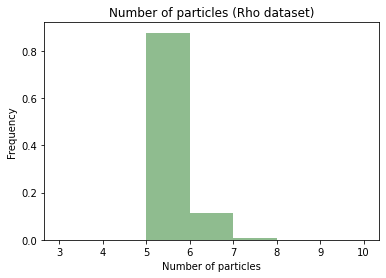

events with one 2 gamma: 87.82179481724182%
events with one 3 gamma: 11.295264031317815%
events with one 4 gamma: 0.7914556827369048%
events with one 5 gamma: 0.03191353559423003%
events with one 6 gamma: 0.0021275690396153355%


In [28]:
# find distribution of number of truth particles in event
num_particles = np.array([len(particle_ids) for particle_ids in events_arr["truthPartPdgId"]])
pu.plot_hist(num_particles, 7, "Number of particles (Rho dataset)", "Number of particles", "Frequency", colour="darkseagreen", discrete=True)

print("events with one 2 gamma:", str(len(num_particles[num_particles == 5])/len(num_particles)*100) + "%")
print("events with one 3 gamma:", str(len(num_particles[num_particles == 6])/len(num_particles)*100) +"%")
print("events with one 4 gamma:", str(len(num_particles[num_particles == 7])/len(num_particles)*100) +"%")
print("events with one 5 gamma:", str(len(num_particles[num_particles == 8])/len(num_particles)*100) +"%")
print("events with one 6 gamma:", str(len(num_particles[num_particles == 9])/len(num_particles)*100) +"%")


/tmp/ipykernel_52171/3022445599.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  num_truth_contributions = np.array([[len(cell_truth_con) for cell_truth_con in event_truth_con] for event_truth_con in events_arr["cluster_cell_hitsTruthIndex"]])


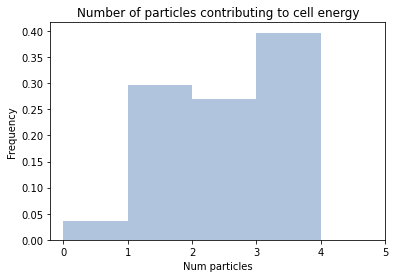

In [29]:
# number of particles contributing to each cell
num_truth_contributions = np.array([[len(cell_truth_con) for cell_truth_con in event_truth_con] for event_truth_con in events_arr["cluster_cell_hitsTruthIndex"]])
pu.plot_hist(flatten_one_layer(num_truth_contributions), 4, "Number of particles contributing to cell energy", "Num particles", "Frequency", xlim=(None, 5), colour="lightsteelblue", discrete=True)

In [19]:
# find events where all cells have no deposits???
# likely from noise cut out!!
no_cell_depoists = [np.count_nonzero(np.array(num_truth_contributions_event) == 0) == len(num_truth_contributions_event) for num_truth_contributions_event in num_truth_contributions]
print("num events with no cell deposits:", np.count_nonzero(no_cell_depoists))

num events with no cell deposits: 0


5


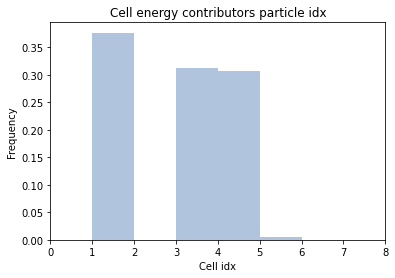

37.636% of energy contributions are from the charged pion and 62.364% are from the gammas


In [20]:
# Of these particles which are depositing energy into the cells
# idx: 0-rho, 1-pi+/-, 2-pi0, 3-gamma, 4-gamma, 5-gamma
truth_part_name = { 0: "rho+/-", 1: "pi+/-", 2: "pi0", 3: "gamma1", 4: "gamma2", 5: "gamma3", 6: "gamma4" }
cell_energy_contr_part_idx = np.array(flatten_layers(events_arr["cluster_cell_hitsTruthIndex"], 2))
print(np.max(cell_energy_contr_part_idx))
pu.plot_hist(cell_energy_contr_part_idx, 5, "Cell energy contributors particle idx", "Cell idx", "Frequency", colour="lightsteelblue", xlim=(0,8), discrete=True) 
print(str(round((len(cell_energy_contr_part_idx[cell_energy_contr_part_idx == 1])/len(cell_energy_contr_part_idx))*100, 3)) + "% of energy contributions are from the charged pion and " + str(round((len(cell_energy_contr_part_idx[cell_energy_contr_part_idx != 1])/len(cell_energy_contr_part_idx))*100, 3)) + "% are from the gammas")


Mean number of clusters: 2.7274725274725276
455


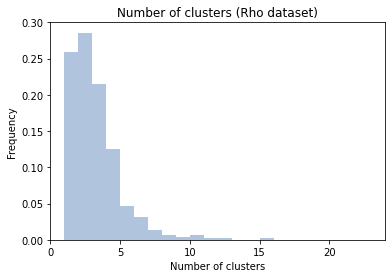

Mean number of tracks: 0.9362637362637363


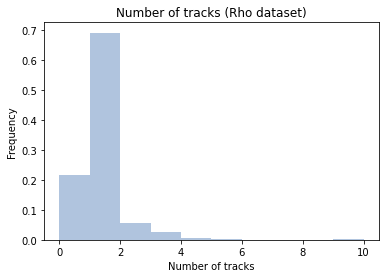

In [21]:
print("Mean number of clusters:", np.mean(events_arr["nCluster"]))
print(len(events_arr["nCluster"]))
pu.plot_hist(np.array(events_arr["nCluster"]), 15, "Number of clusters (Rho dataset)", "Number of clusters", "Frequency", colour="lightsteelblue", discrete=True, xlim=(0, 24))

print("Mean number of tracks:", np.mean(events_arr["nTrack"]))
pu.plot_hist(np.array(events_arr["nTrack"]), 10, "Number of tracks (Rho dataset)", "Number of tracks", "Frequency", colour="lightsteelblue", discrete=True)

In [30]:
# how much energy are these single particles depositing into the cells
part_energy_deposits = np.array(flatten_layers(events_arr["cluster_cell_hitsTruthE"], 2))
print(len(part_energy_deposits))
pu.plot_hist(part_energy_deposits, 100, "Energy deposits by one particle into one cell", "Energy (MeV)", "Frequency", colour="lightsteelblue")
pu.plot_hist(part_energy_deposits[part_energy_deposits < 2000], 100, "Energy deposits by one particle into one cell (< 2000)", "Energy (MeV)", "Frequency", colour="lightsteelblue")
#pu.plot_hist(part_energy_deposits[part_energy_deposits < 0], 100, "Energy deposited by one particle into one cell (< 0)", "Energy (MeV)", "Frequency", colour="lightsteelblue")
print("range:", round(np.min(part_energy_deposits), 4), "->", np.max(part_energy_deposits))
print("energy deposits < 0:", str(round(len(part_energy_deposits[part_energy_deposits < 0])/len(part_energy_deposits), 5)*100) + "%")
print("energy deposits < 2000:", str(round(len(part_energy_deposits[part_energy_deposits < 2000])/len(part_energy_deposits), 5)*100) + "%")

# percent of events with a neg cell deposit
part_energy_deposits_events = np.array([np.count_nonzero([cell_part_deposit < 0 for cell_part_deposit in flatten_layers(event_part_deposits, 1)]) > 0 for event_part_deposits in events_arr["cluster_cell_hitsTruthE"]])
num_events = len(events_arr["cluster_cell_hitsTruthE"])
print("events with a neg energy deposit:", str(round(np.count_nonzero(part_energy_deposits_events) / num_events, 5)*100) + "%")

KeyboardInterrupt: 

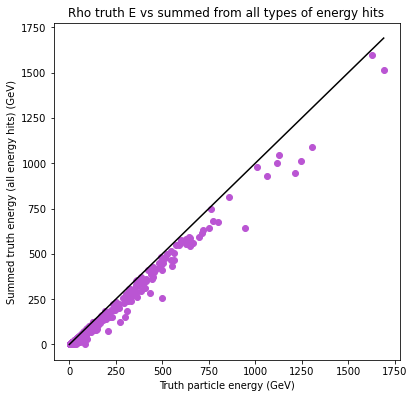

count where truth_E_1 < truth_E_2: 0
frac where truth_E_1 < truth_E_2: 0.0


In [30]:
def plot_truth_E_comparison(truth_E_1, truth_E_2, title, xlabel, ylabel, lim=None):
    fig = plt.figure(figsize=(6.2,6.2))
    fig.patch.set_facecolor('white')
    plt.scatter(truth_E_1, truth_E_2, color="mediumorchid")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(np.arange(np.max(truth_E_1)), np.arange(np.max(truth_E_1)), color="black")
    plt.xlim(lim)
    plt.ylim(lim)
    plt.show()

    print("count where truth_E_1 < truth_E_2:", np.count_nonzero(truth_E_1 < truth_E_2))
    print("frac where truth_E_1 < truth_E_2:", np.count_nonzero(truth_E_1 < truth_E_2)/len(truth_E_1))

# get the truth part value for the part of idx 1: Rho
truth_part_E_rho = events_arr["truthPartE"][:,0]

# sum E hits EM, non EM, escaped, and invisible - keep same shape
list_truth_part_E = ak.Array(events_arr["cluster_cell_hitsE_EM"]) + ak.Array(events_arr["cluster_cell_hitsE_nonEM"]) + ak.Array(events_arr["cluster_cell_hitsE_Escaped"]) + ak.Array(events_arr["cluster_cell_hitsE_Invisible"])

# sum all hits over event to get summed truth E from different energies 
summed_truth_part_E_rho = [np.sum([cell_truth_part_E for cell_truth_part_E in event_truth_part_E]) for event_truth_part_E in list_truth_part_E]

plot_truth_E_comparison(truth_part_E_rho, summed_truth_part_E_rho, "Rho truth E vs summed from all types of energy hits","Truth particle energy (GeV)", "Summed truth energy (all energy hits) (GeV)")

Lead particle energy deposit analysis

Find $\Delta$ R between charged and neutral pions

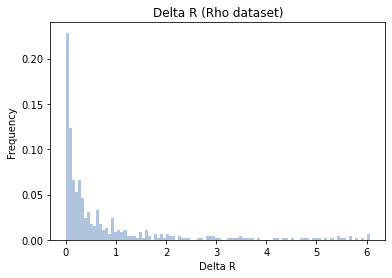

'\npipm_thetas = [2*np.arctan(np.exp(-eta)) for eta in pipm_etas]\npi0_thetas = [2*np.arctan(np.exp(-eta)) for eta in pi0_etas]\n\ndelta_R2 = np.cos(-1)*(np.cos(pipm_thetas)*np.cos(pi0_thetas) + np.sin(pipm_thetas)*np.sin(pi0_thetas)*np.cos(pipm_phis - pi0_phis))\npu.plot_hist(delta_R2, 100, "Delta R2 (Rho dataset)", "Delta R", "Frequency", colour="lightsteelblue")\n'

In [22]:
pipm_idx = 1
pi0_idx = 2

pipm_etas = np.array(events_arr['truthPartEta'][:, pipm_idx])
pipm_phis = np.array(events_arr['truthPartPhi'][:, pipm_idx])

pi0_etas = np.array(events_arr['truthPartEta'][:, pi0_idx])
pi0_phis = np.array(events_arr['truthPartPhi'][:, pi0_idx])

# angular separation between the vectors in the eta/phi plane - over events
delta_R = np.sqrt((pipm_etas - pi0_etas)**2 + (pipm_phis - pi0_phis)**2)

pu.plot_hist(delta_R, 100, "Delta R (Rho dataset)", "Delta R", "Frequency", colour="lightsteelblue")

"""
pipm_thetas = [2*np.arctan(np.exp(-eta)) for eta in pipm_etas]
pi0_thetas = [2*np.arctan(np.exp(-eta)) for eta in pi0_etas]

delta_R2 = np.cos(-1)*(np.cos(pipm_thetas)*np.cos(pi0_thetas) + np.sin(pipm_thetas)*np.sin(pi0_thetas)*np.cos(pipm_phis - pi0_phis))
pu.plot_hist(delta_R2, 100, "Delta R2 (Rho dataset)", "Delta R", "Frequency", colour="lightsteelblue")
"""

In [269]:
# cut out events with all energy deposits pi0 or pi+/-
frac_pi0_energy = ak.Array([np.array([(np.sum(np.array(cell_energy_contr)[np.array(events_arr["cluster_cell_hitsTruthIndex"][event_idx][cell_idx]) != 1])/np.sum(cell_energy_contr)) if np.count_nonzero(events_arr["cluster_cell_hitsTruthIndex"][event_idx][cell_idx] != 1) else 0 for cell_idx, cell_energy_contr in enumerate(event_energy_contr)]) for event_idx, event_energy_contr in enumerate(events_arr["cluster_cell_hitsTruthE"])])
frac_cells_fully_pi0_in_event = np.array([np.count_nonzero(np.array(frac_pi0_energy_event) == 1)/len(frac_pi0_energy_event) for frac_pi0_energy_event in frac_pi0_energy])
frac_cells_fully_pipm_in_event = np.array([np.count_nonzero(np.array(frac_pi0_energy_event) == 0)/len(frac_pi0_energy_event) for frac_pi0_energy_event in frac_pi0_energy])

# cut out events with only pi0 or pi+/- deposits
"""
events_arr_resized = {}
for key in events.items():
    events_arr_resized[key[0]] = ak.Array(events_arr[key[0]])[(frac_cells_fully_pi0_in_event != 1) & (frac_cells_fully_pipm_in_event != 1)]

events_arr = events_arr_resized
"""

'\nevents_arr_resized = {}\nfor key in events.items():\n    events_arr_resized[key[0]] = ak.Array(events_arr[key[0]])[(frac_cells_fully_pi0_in_event != 1) & (frac_cells_fully_pipm_in_event != 1)]\n\nevents_arr = events_arr_resized\n'

In [31]:
# get cell fracs
#lead_contribution_frac = ak.Array([[np.max(cell_energy_contr)/np.sum(cell_energy_contr) if len(cell_energy_contr) else 0 for cell_energy_contr in event_energy_contr] for event_energy_contr in events_arr["cluster_cell_hitsTruthE"]])
frac_pi0_energy = ak.Array([ak.sum(events_arr["cluster_cell_hitsTruthE"][event_idx][event_clus_cell_hitsTruthIndex != 1], axis=1)/ak.sum(events_arr["cluster_cell_hitsTruthE"][event_idx], axis=1) for event_idx, event_clus_cell_hitsTruthIndex in enumerate(events_arr["cluster_cell_hitsTruthIndex"])])
empty_contr_frac = ak.Array([np.isnan(frac_pi0_energy_event) for frac_pi0_energy_event in frac_pi0_energy])

/usr/local/lib/python3.8/dist-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


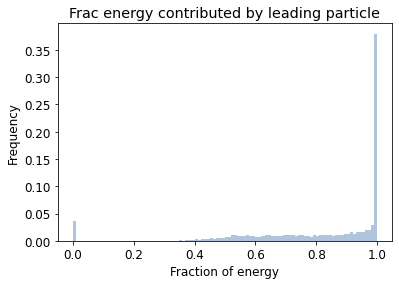

frac cells with only one particle deposit: 0.31091481546265526


In [314]:
delta_R_cut = 0.05
flat_lead_contr_frac = flatten_layers(lead_contribution_frac[~empty_contr_frac], 1)

pu.plot_hist(np.array(flat_lead_contr_frac), 100, "Frac energy contributed by leading particle", "Fraction of energy", "Frequency", colour="lightsteelblue")
#pu.plot_hist(np.array(flat_lead_contr_frac[delta_R < delta_R_cut]), 100, "Frac energy contributed by leading particle (Delta R<" + str(delta_R_cut) +")", "Fraction of energy", "Frequency", colour="lightsteelblue")

print("frac cells with only one particle deposit:", np.count_nonzero(np.array(flat_lead_contr_frac) == 1)/len(flat_lead_contr_frac))

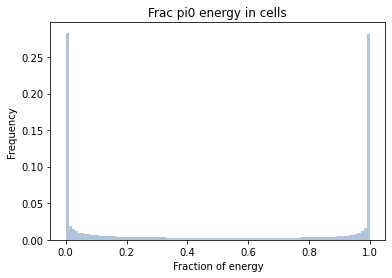

In [32]:
flat_frac_pi0_energy = flatten_layers(frac_pi0_energy[~empty_contr_frac], 1)

pu.plot_hist(np.array(flat_frac_pi0_energy), 100, "Frac pi0 energy in cells", "Fraction of energy", "Frequency", colour="lightsteelblue")
#pu.plot_hist(np.array(flat_frac_pipm_energy[delta_R < delta_R_cut]), 100, "Frac pi+/- energy in cells (Delta R<" + str(delta_R_cut) +")", "Fraction of energy", "Frequency", colour="lightsteelblue")

frac events full pi0 deposits: 0.020552316922684142


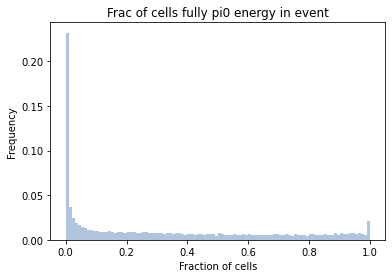

frac events full pi+/- deposits: 0.0126803114761074


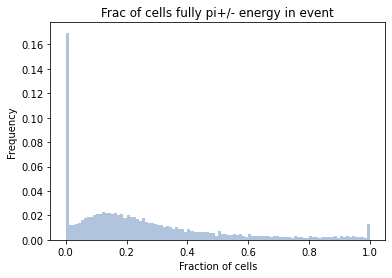

In [33]:
# in the events what % have deposits from both types of pions
# (plot frac cells fully pi+/- and then plot frac cells fully pi0)
frac_cells_fully_pi0_in_event = np.array([np.count_nonzero(np.array(frac_pi0_energy_event) == 1)/len(frac_pi0_energy_event) for frac_pi0_energy_event in frac_pi0_energy])
frac_cells_fully_pipm_in_event = np.array([np.count_nonzero(np.array(frac_pi0_energy_event) == 0)/len(frac_pi0_energy_event) for frac_pi0_energy_event in frac_pi0_energy])

print("frac events full pi0 deposits:", np.count_nonzero(np.array(frac_cells_fully_pi0_in_event) == 1)/len(frac_cells_fully_pi0_in_event))
pu.plot_hist(frac_cells_fully_pi0_in_event, 100, "Frac of cells fully pi0 energy in event", "Fraction of cells", "Frequency", colour="lightsteelblue")

print("frac events full pi+/- deposits:", np.count_nonzero(np.array(frac_cells_fully_pipm_in_event) == 1)/len(frac_cells_fully_pi0_in_event))
pu.plot_hist(frac_cells_fully_pipm_in_event, 100, "Frac of cells fully pi+/- energy in event", "Fraction of cells", "Frequency", colour="lightsteelblue")


0.14035572954342368


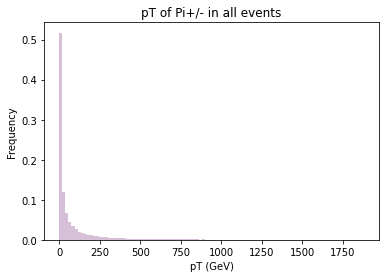

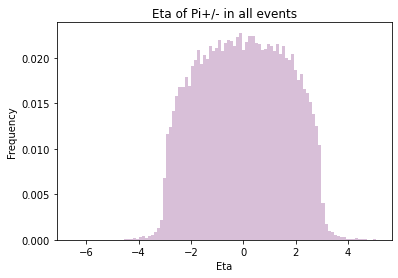

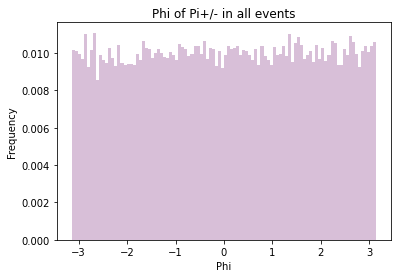

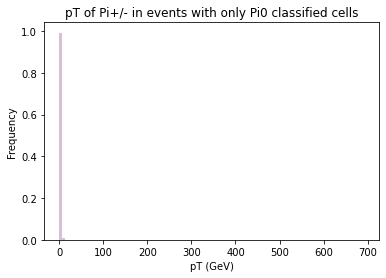

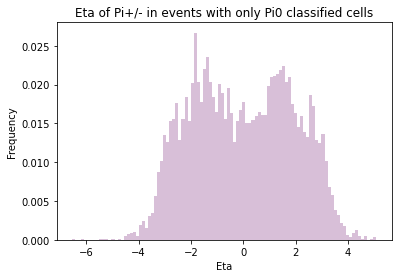

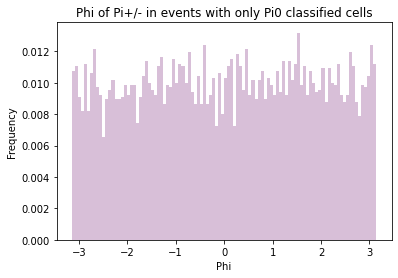

In [40]:
# check the eta, phi, E of the pi+/- particles in the events where only pi0 is depositing energy
cut_fully_pi0_classified_events = np.array(frac_cells_majority_pi0_in_event) == 1
pipm_truth_part_idx = 1

print(np.count_nonzero(cut_fully_pi0_classified_events)/len(cut_fully_pi0_classified_events))

pu.plot_hist(np.array(events_arr["truthPartPt"][:, pipm_truth_part_idx]), 100, "pT of Pi+/- in all events", "pT (GeV)", "Frequency", colour="thistle")
pu.plot_hist(np.array(events_arr["truthPartEta"][:, pipm_truth_part_idx]), 100, "Eta of Pi+/- in all events", "Eta", "Frequency", colour="thistle")
pu.plot_hist(np.array(events_arr["truthPartPhi"][:, pipm_truth_part_idx]), 100, "Phi of Pi+/- in all events", "Phi", "Frequency", colour="thistle")


pu.plot_hist(np.array(events_arr["truthPartPt"][:, pipm_truth_part_idx])[cut_fully_pi0_classified_events], 100, "pT of Pi+/- in events with only Pi0 classified cells", "pT (GeV)", "Frequency", colour="thistle")
pu.plot_hist(np.array(events_arr["truthPartEta"][:, pipm_truth_part_idx])[cut_fully_pi0_classified_events], 100, "Eta of Pi+/- in events with only Pi0 classified cells", "Eta", "Frequency", colour="thistle")
pu.plot_hist(np.array(events_arr["truthPartPhi"][:, pipm_truth_part_idx])[cut_fully_pi0_classified_events], 100, "Phi of Pi+/- in events with only Pi0 classified cells", "Phi", "Frequency", colour="thistle")

In [35]:
# classify the cells based on majority pi+/- or pi0
class_frac_pi0_energy = frac_pi0_energy[~empty_contr_frac] > 0.5

print("frac cells pi0 class:", np.count_nonzero(class_frac_pi0_energy)/len(flatten_one_layer(class_frac_pi0_energy)))
print("frac cells pi+/- class:", 1 - np.count_nonzero(class_frac_pi0_energy)/len(flatten_one_layer(class_frac_pi0_energy)))


frac cells pi0 class: 0.47900960713599144
frac cells pi+/- class: 0.5209903928640085


frac events with pi0 majority deposits: 0.5791668439640867
frac events with pi+/- majority deposits: 0.42083315603591337


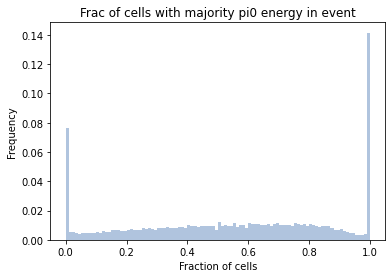

In [36]:
# in the events what frac of cells have the majority of their energy from pi+/-

frac_cells_majority_pi0_in_event = np.array([np.count_nonzero(class_frac_pi0_energy_event)/len(class_frac_pi0_energy_event) for class_frac_pi0_energy_event in class_frac_pi0_energy])
print("frac events with pi0 majority deposits:", np.count_nonzero(np.array(frac_cells_majority_pi0_in_event) >= 0.5)/len(frac_cells_majority_pi0_in_event))
print("frac events with pi+/- majority deposits:", np.count_nonzero(np.array(frac_cells_majority_pi0_in_event) < 0.5)/len(frac_cells_majority_pi0_in_event))

pu.plot_hist(frac_cells_majority_pi0_in_event, 100, "Frac of cells with majority pi0 energy in event", "Fraction of cells", "Frequency", colour="lightsteelblue")


In [75]:
# find fastest way to sum

# A - sum for each event separately

# i - old method:
num_events = 3

start_time = time.perf_counter()
for event_idx in range(num_events):
    frac_pi0_energy = ([(np.sum(np.array(cell_energy_contr)[np.array(events_arr["cluster_cell_hitsTruthIndex"][event_idx][cell_idx]) != 1])/np.sum(cell_energy_contr)) if np.count_nonzero(events_arr["cluster_cell_hitsTruthIndex"][event_idx][cell_idx] != 1) else 0 for cell_idx, cell_energy_contr in enumerate(events_arr["cluster_cell_hitsTruthE"][event_idx])])
end_time = time.perf_counter()
print(frac_pi0_energy[4])
print("avg event processing time:", (end_time - start_time)/num_events)

# ii - new method:
start_time = time.perf_counter()
for event_idx in range(num_events):
    frac_pi0_energy = ak.sum(events_arr["cluster_cell_hitsTruthE"][event_idx][events_arr["cluster_cell_hitsTruthIndex"][event_idx] != 1], axis=1)/ak.sum(events_arr["cluster_cell_hitsTruthE"][event_idx], axis=1)
end_time = time.perf_counter()
print(frac_pi0_energy[4])
print("avg event processing time:", (end_time - start_time)/num_events)

0.43858613679585545
avg event processing time: 0.07846536366560031
0.43858613679585545
avg event processing time: 0.003128702664980665


In [41]:
# distribute cell energy based on classification and compare to truth energy of the event

pi0_event_energy_based_on_classification = [np.sum(event_truth_E_deposits, axis=None) for event_truth_E_deposits in ak.Array(events_arr["cluster_cell_hitsTruthE"])[class_frac_pi0_energy == 1]]
pi0_event_truth_energy = [np.sum(event_truth_E_deposits[events_arr["cluster_cell_hitsTruthIndex"][event_idx] != 1]) for event_idx, event_truth_E_deposits in enumerate(ak.Array(events_arr["cluster_cell_hitsTruthE"]))]

plot_truth_E_comparison(pi0_event_truth_energy, pi0_event_energy_based_on_classification, "Pi0 truth energy summed from cells vs summed from pi0 classified cells","Truth energy (GeV)", "Summed from classified cells (GeV)", (None, 1000000))
plot_truth_E_comparison(pi0_event_truth_energy, pi0_event_energy_based_on_classification, "Pi0 truth energy summed from cells vs summed from pi0 classified cells","Truth energy (GeV)", "Summed from classified cells (GeV)", (0, 100000))
plot_truth_E_comparison(pi0_event_truth_energy, pi0_event_energy_based_on_classification, "Pi0 truth energy summed from cells vs summed from pi0 classified cells","Truth energy (GeV)", "Summed from classified cells (GeV)", (0, 10000))


NameError: name 'plot_truth_E_comparison' is not defined

In [36]:
# get event idxs where all cells are pi+/- or pi0
event_idx = np.arange(len(events_arr["cluster_cell_hitsTruthE"]))

events_with_all_pi0_deposits = event_idx[frac_cells_fully_pi0_in_event == 1]
events_with_all_pipm_deposits = event_idx[frac_cells_fully_pipm_in_event == 1]

46
46
Delta R: 3.4598095
pi+/- eta: [-1.72, -1.84, -1.57, -1.6, -1.53] phi: [-1.78, -1.2, -2.01, -2.03, -2]
calc deltaR: 0.8621752512159615
truth part ID: [-213, -211, 111, 22, 22]
truth part E: [14.6, 5.08, 9.53, 5.2, 4.33]
num pi+/- frac == 1: 19
num pi+/- frac != 1: 26
summed E from pi+/-: 2.784598035812378
summed E from pi0: 3.4620501499176024
cell EM: [0.0207, 0.00156, 0.0243, 0.000698, 0.0877, ... 0.00692, 0.000296, 0.00315, 0.0141]
cell non EM: [0.000137, 4.52e-05, 0.000372, 1.03e-05, ... 0.00142, 0.0102, 0.0282, 0.0195]
cell escaped: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
cell invisible: [4.47e-17, -1.46e-19, -2.12e-18, 1.87e-19, ... 0.00995, 1.65e-14, 0.0121, -0.000577]
summed over types of E: 6.24664825135981
truth part cell deposits Idx: [3]
truth part cell deposits E: [20.8]
event index: 0
pipm_frac: [0. 0. 0.]
num cells: 46


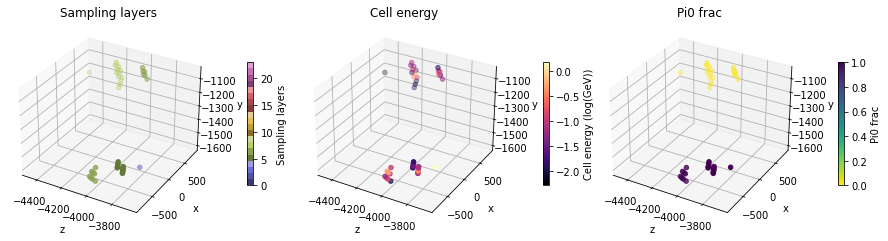

151
151
Delta R: 0.8621752
pi+/- eta: [1.57, 1.58, 1.51, 1.53, 1.5] phi: [-1.24, -1.18, -1.39, -1.39, -1.39]
calc deltaR: 0.22066683905621967
truth part ID: [213, 211, 111, 22, 22]
truth part E: [75.5, 55.9, 19.6, 6.24, 13.4]
num pi+/- frac == 1: 141
num pi+/- frac != 1: 46
summed E from pi+/-: 38.9924599685669
summed E from pi0: 1.0167382583618163
cell EM: [0.183, 0.252, 0.00241, 0, 0.00269, ... 0.0175, 0.000195, 0.092, 0.0114, 0.0581]
cell non EM: [0.00447, 0.00481, 4.62e-05, 3.21e-06, 0.000102, ... 0.000196, 0.331, 0.1, 0.35]
cell escaped: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0896]
cell invisible: [3.72e-17, 3.76e-16, 0, 0, -3.87e-15, 0, ... 0.0551, 0.000148, 0.0983, 0.03, 0.0361]
summed over types of E: 40.00919828755519
truth part cell deposits Idx: [3, 4]
truth part cell deposits E: [0.0989, 188]
event index: 1
pipm_frac: []
num cells: 151


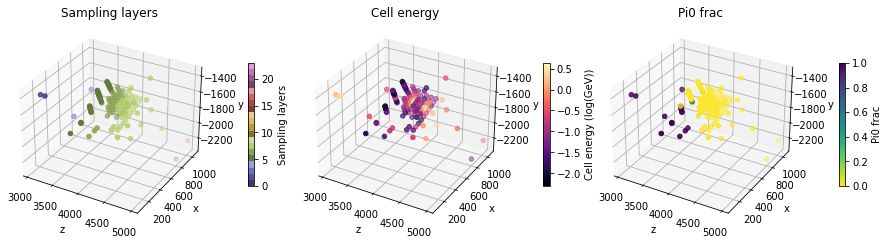

86
86
Delta R: 0.22066684
pi+/- eta: [-1.52, -1.56, -1.48, -1.47, -1.5] phi: [0.0794, 0.0768, 0.0823, 0.0805, 0.0839]
calc deltaR: 0.07352401417184513
truth part ID: [-213, -211, 111, 22, 22]
truth part E: [45.8, 25.6, 20.2, 9.18, 11]
num pi+/- frac == 1: 68
num pi+/- frac != 1: 58
summed E from pi+/-: 20.530415920257568
summed E from pi0: 2.9360008659362795
cell EM: [0.225, 0.509, 0.203, 0.00128, 0.00471, ... 0.121, 0.00535, 0.385, 0.14, 0.0176]
cell non EM: [0.00275, 0.0056, 0.0026, 4.04e-06, 0.000137, ... 0.000425, 0.463, 0.0295, 0.0984]
cell escaped: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0903, 0, 0]
cell invisible: [0.00743, 2.69e-15, 9.8e-06, 7.96e-16, ... 8.53e-05, 0.0642, -1.15e-16, 0.109]
summed over types of E: 23.466416826051983
truth part cell deposits Idx: [1, 3, 4]
truth part cell deposits E: [0.242, 1.19, 234]
event index: 2
pipm_frac: [0. 0.]
num cells: 86


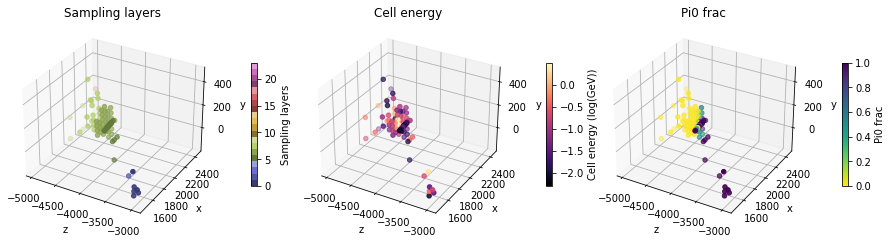

120
120
Delta R: 0.07352401
pi+/- eta: [-1.51, -1.5, -1.51, -1.51, -1.51] phi: [1.37, 1.32, 1.37, 1.37, 1.37]
calc deltaR: 0.04648343878536527
truth part ID: [-213, -211, 111, 22, 22]
truth part E: [210, 16.3, 194, 146, 47.8]
num pi+/- frac == 1: 19
num pi+/- frac != 1: 228
summed E from pi+/-: 0.6880597534179688
summed E from pi0: 75.13977847290039
cell EM: [0.0357, 0.0352, 0.243, 0.255, 0.0601, 0.505, ... 0.207, 0, 0.324, 0.138, 0.0282]
cell non EM: [0.00169, 0.00221, 0.00614, 0.00485, 0.00118, ... 0.000203, 0.0142, 0.00677, 0.00332]
cell escaped: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
cell invisible: [0.000136, 6.47e-18, 3.75e-18, 1.4e-05, ... 0, -1.57e-16, 1.94e-16, 1.55e-18]
summed over types of E: 75.82783843960357
truth part cell deposits Idx: [4, 3]
truth part cell deposits E: [10.5, 27]
event index: 3
pipm_frac: [0. 0.]
num cells: 120


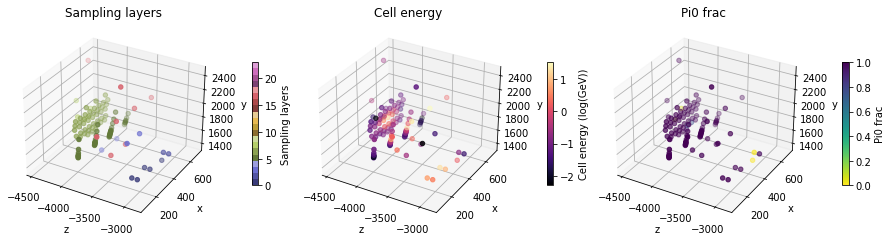

119
119
Delta R: 0.04648344
pi+/- eta: [-0.142, -0.113, -0.161, -0.16, -0.161] phi: [-0.836, -0.851, -0.826, -0.822, -0.828]
calc deltaR: 0.05334579924829015
truth part ID: [213, 211, 111, 22, 22]
truth part E: [92.9, 36, 56.9, 11.4, 45.6]
num pi+/- frac == 1: 35
num pi+/- frac != 1: 160
summed E from pi+/-: 34.59985371541977
summed E from pi0: 55.66905284023285
cell EM: [0, 0, 0.00044, 0.000252, 5.55e-05, ... 0.0048, 0, 0.139, 8.58e-05, 0.000106]
cell non EM: [0.00501, 0.000237, 1.97e-05, 0, 5.75e-06, ... 8.83e-05, 1.39, 4.44e-05, 0.00118]
cell escaped: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0901, 0, 0]
cell invisible: [-2.37e-15, 0, 3.52e-15, 0, -1.55e-14, ... 5.68e-16, 0, 0.492, -8.87e-15, 6.9e-05]
summed over types of E: 90.26890637844316
truth part cell deposits Idx: [4, 1]
truth part cell deposits E: [0.0604, 4.95]
event index: 4
pipm_frac: [0. 0. 0. 0. 0. 0. 0. 0. 0.]
num cells: 119


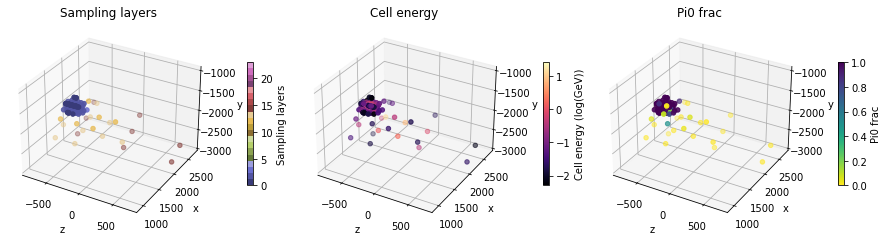

62
62
Delta R: 0.66795015
pi+/- eta: [-0.333, -0.958, -0.176, -0.169, -0.18] phi: [-2.96, -2.26, -3.08, -3.09, -3.07]
calc deltaR: 1.1326180166269841
truth part ID: [-213, -211, 111, 22, 22]
truth part E: [12.8, 2.77, 9.98, 4.29, 5.69]
num pi+/- frac == 1: 13
num pi+/- frac != 1: 84
summed E from pi+/-: 0.8594735107421875
summed E from pi0: 9.09910341644287
cell EM: [0.00827, 0.0544, 0.00856, 0.0273, 0.0507, ... 0.00543, 0.000822, 0.000238, 0.0188]
cell non EM: [5.07e-05, 0.000567, 0.000461, 0.000822, ... 0.0382, 0.000163, 0.000487, 0.0245]
cell escaped: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
cell invisible: [-7.17e-17, 7.91e-16, 6.02e-19, -1.19e-19, ... 3.74e-17, 6.25e-15, 0, 0.0593]
summed over types of E: 9.958576864264614
truth part cell deposits Idx: [4, 3]
truth part cell deposits E: [0.0507, 8.27]
event index: 5
pipm_frac: [0. 0. 0.]
num cells: 62


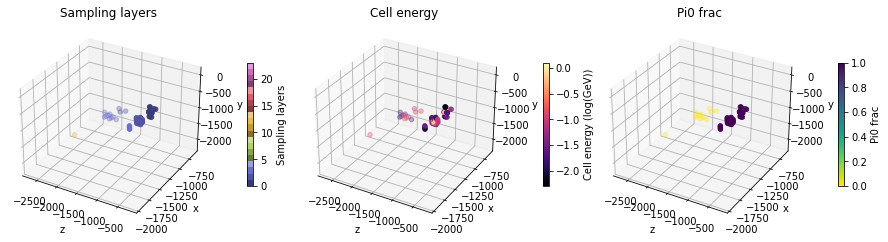

216
216
Delta R: 0.0533458
pi+/- eta: [0.207, 0.213, 0.206, 0.205, 0.207] phi: [-0.784, -0.786, -0.783, -0.783, -0.783]
calc deltaR: 0.007576349803236487
truth part ID: [213, 211, 111, 22, 22]
truth part E: [325, 69.4, 256, 211, 45.3]
num pi+/- frac == 1: 110
num pi+/- frac != 1: 330
summed E from pi+/-: 57.057348424911495
summed E from pi0: 250.28480701637267
cell EM: [0.000272, 0.014, 0.156, 0.00196, 8.83e-05, ... 0.00719, 0.00163, 0.0135, 0.00808]
cell non EM: [0.000137, 0.00448, 0.00246, 0.000908, 0.000587, ... 0.0416, 0.00147, 0.0165, 0.143]
cell escaped: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
cell invisible: [0, -5.98e-15, 3.06e-15, 4.16e-19, 0, ... 0.0002, 0.0575, 1.25e-05, 0.0243, 0.0406]
summed over types of E: 307.3421516226506
truth part cell deposits Idx: [3, 4]
truth part cell deposits E: [0.119, 0.289]
event index: 6
pipm_frac: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
num cells: 216


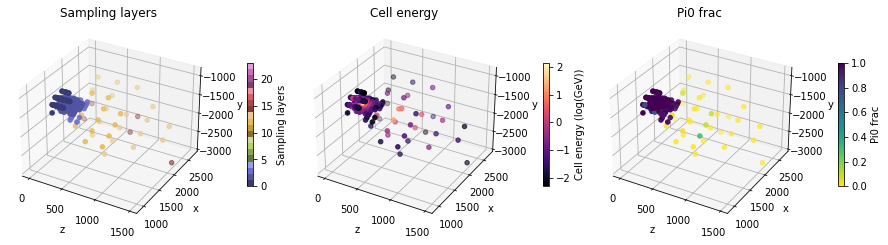

34
34
Delta R: 1.1326181
pi+/- eta: [-2.67, -1.94, -2.76, -2.79, -2.75] phi: [-1.37, -0.83, -1.5, -1.5, -1.5]
calc deltaR: 1.0559000363217903
truth part ID: [-213, -211, 111, 22, 22]
truth part E: [75.1, 7.65, 67.5, 16.9, 50.6]
num pi+/- frac == 1: 20
num pi+/- frac != 1: 24
summed E from pi+/-: 3.3001483268737792
summed E from pi0: 55.199271774291994
cell EM: [0.774, 2.1, 1.63, 0.208, 4.16, 33.8, ... 0.068, 0.236, 0.302, 0.017, 0.0457, 0.0041]
cell non EM: [0.0252, 0.0651, 0.0355, 0.00569, 0.0703, ... 0.00243, 0.00115, 0.000398, 0.000317]
cell escaped: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
cell invisible: [-9.07e-16, 0.000826, 5.23e-05, 1.09e-14, ... 4.56e-19, -8.16e-19, -5.57e-20]
summed over types of E: 58.49942167482506
truth part cell deposits Idx: [3, 4]
truth part cell deposits E: [74.9, 724]
event index: 7
pipm_frac: [0. 0. 0.]
num cells: 34


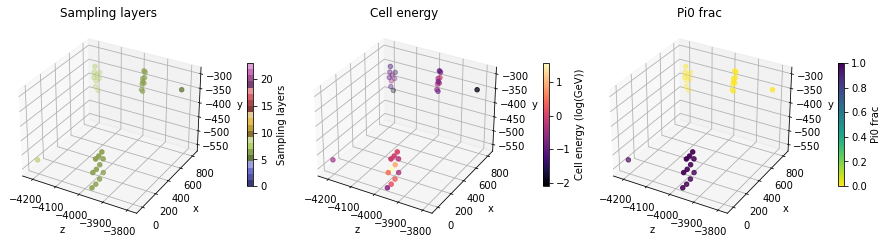

57
57
Delta R: 0.0075763497
pi+/- eta: [2.51, 2.59, 2.51, 2.51, 2.5] phi: [-0.296, -0.666, -0.286, -0.284, -0.287]
calc deltaR: 0.38888873564188986
truth part ID: [-213, -211, 111, 22, 22]
truth part E: [179, 5.02, 174, 44.3, 130]
num pi+/- frac == 1: 10
num pi+/- frac != 1: 114
summed E from pi+/-: 0.11881600761413574
summed E from pi0: 140.99861083984376
cell EM: [0.0489, 0.0817, 0.107, 0.295, 0.14, 0.557, ... 0.653, 0.163, 0.319, 0.213, 0.849]
cell non EM: [0.00225, 0.00419, 0.00448, 0.0113, 0.00228, ... 0.0041, 0.00632, 0.0559, 0.185]
cell escaped: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
cell invisible: [9.61e-20, 3.67e-18, 2.38e-15, -4.57e-15, ... -4.59e-18, -2.62e-15, -1.51e-17]
summed over types of E: 141.11742560787755
truth part cell deposits Idx: [3, 4]
truth part cell deposits E: [3.79, 47.4]
event index: 8
pipm_frac: []
num cells: 57


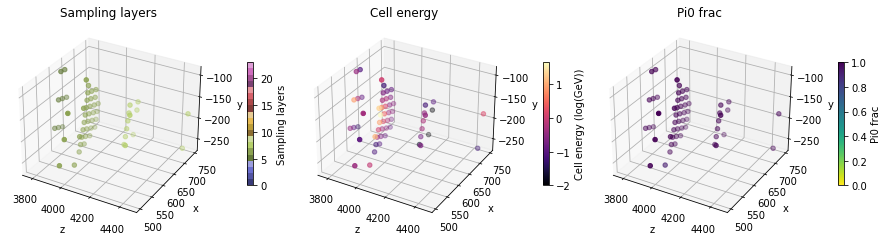

137
137
Delta R: 1.0559001
pi+/- eta: [2.23, 2.42, 2.11, 2.11, 2.09] phi: [0.271, 0.252, 0.281, 0.281, 0.234]
calc deltaR: 0.31464441653478215
truth part ID: [213, 211, 111, 22, 22]
truth part E: [154, 65.1, 88.7, 87.3, 1.36]
num pi+/- frac == 1: 110
num pi+/- frac != 1: 134
summed E from pi+/-: 45.19619802188873
summed E from pi0: 84.44682043242454
cell EM: [0.0269, 0.0207, 0.011, 0.011, 0.0211, ... 0.0144, 0.0373, 0.0141, 0.0989, 1.39]
cell non EM: [0.0012, 0.000671, 0.00136, 0.000681, 0.000914, ... 0.11, 0.00406, 0.244, 0.174]
cell escaped: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
cell invisible: [1.19e-18, 3.41e-16, 1.52e-19, -1.09e-18, ... 0.167, 3.3e-15, 0.101, 0.0182]
summed over types of E: 129.6430190220347
truth part cell deposits Idx: [4, 3]
truth part cell deposits E: [1.82, 26.3]
event index: 9
pipm_frac: []
num cells: 137


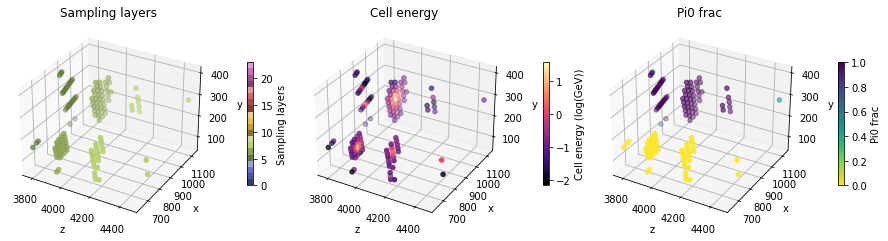

In [37]:
# visualize cell deposit frac from pi+/- ^^
for event_idx in np.arange(10):#events_with_all_pipm_deposits[:5]:
    #print(frac_pipm_energy[event_idx][np.array(empty_contr_frac[event_idx])])
    print(len(frac_pi0_energy[event_idx]))
    print(len(np.array(empty_contr_frac[event_idx])))

    print("Delta R:", delta_R[event_idx])
    print("pi+/- eta:", events_arr["truthPartEta"][event_idx], "phi:", events_arr["truthPartPhi"][event_idx])
    print("calc deltaR:", np.sqrt((events_arr["truthPartEta"][event_idx][1] - events_arr["truthPartEta"][event_idx][2])**2 + (events_arr["truthPartPhi"][event_idx][1] - events_arr["truthPartPhi"][event_idx][2])**2))
    print("truth part ID:", events_arr["truthPartPdgId"][event_idx])
    print("truth part E:", events_arr["truthPartE"][event_idx])
    print("num pi+/- frac == 1:", np.count_nonzero(ak.Array(events_arr["cluster_cell_hitsTruthIndex"][event_idx]) == 1))
    print("num pi+/- frac != 1:", np.count_nonzero(ak.Array(events_arr["cluster_cell_hitsTruthIndex"][event_idx]) != 1))
    print("summed E from pi+/-:", np.sum(ak.Array(events_arr["cluster_cell_hitsTruthE"][event_idx])[ak.Array(events_arr["cluster_cell_hitsTruthIndex"][event_idx]) == 1], axis=None)/1000)
    print("summed E from pi0:", np.sum(ak.Array(events_arr["cluster_cell_hitsTruthE"][event_idx])[ak.Array(events_arr["cluster_cell_hitsTruthIndex"][event_idx]) != 1], axis=None)/1000)
    print("cell EM:", events_arr["cluster_cell_hitsE_EM"][event_idx])
    print("cell non EM:", events_arr["cluster_cell_hitsE_nonEM"][event_idx])
    print("cell escaped:", events_arr["cluster_cell_hitsE_Escaped"][event_idx])
    print("cell invisible:", events_arr["cluster_cell_hitsE_Invisible"][event_idx])
    print("summed over types of E:", np.sum(events_arr["cluster_cell_hitsE_EM"][event_idx] + events_arr["cluster_cell_hitsE_nonEM"][event_idx] + events_arr["cluster_cell_hitsE_Escaped"][event_idx] + events_arr["cluster_cell_hitsE_Invisible"][event_idx], axis=None))
    print("truth part cell deposits Idx:", events_arr["cluster_cell_hitsTruthIndex"][event_idx][0])
    print("truth part cell deposits E:", events_arr["cluster_cell_hitsTruthE"][event_idx][0])


    plot_event_3d_info(event_idx, np.array(frac_pi0_energy[event_idx]), np.array(empty_contr_frac[event_idx]))
